In [1]:
# Imports
import numpy as np
from scipy.io import loadmat
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, LSTM, SimpleRNN, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten
import keras.backend as K
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils import Sequence, to_categorical

Using TensorFlow backend.


## Import the IMU Data

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


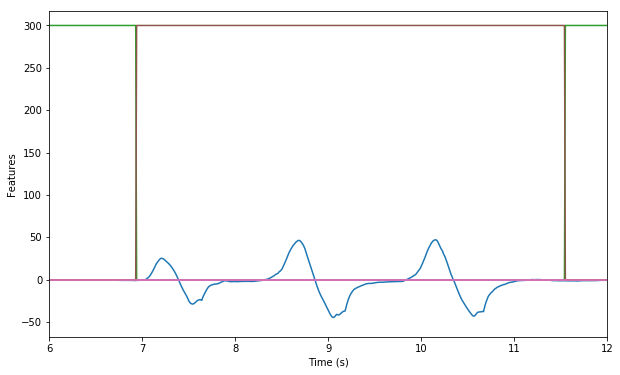

In [3]:
# Import the data from the mat file

data_in = loadmat('../Datasets/ashwin_testdata/walk_data_ashwin.mat')
X = data_in['imu_features']
Y = data_in['lm_label']/300
Ytemp = np.argwhere(Y)[:, 1]
Yint = np.zeros(Ytemp.shape)
for i in range(Ytemp.shape[0]):
    if Ytemp[i] == 1:
        Yint[i] = 0
    elif Ytemp[i] == 4:
        Yint[i] = 1
    elif Ytemp[i] == 5:
        Yint[i] = 2
            
Y_prep = to_categorical(Yint)
print(Y_prep)

# Get some statistics from the data
exp_dur = X.shape[0]/100.0
nfeat = X.shape[1]
t = np.linspace(0, exp_dur, X.shape[0])

# Plot parts of the data
plt.figure(figsize=(10, 6))
plt.plot(t, X[:, 56])
plt.plot(t, Y*300)
plt.xlim([6, 12])
plt.ylabel('Features')
plt.xlabel('Time (s)')
plt.show()

## Preprocess the data

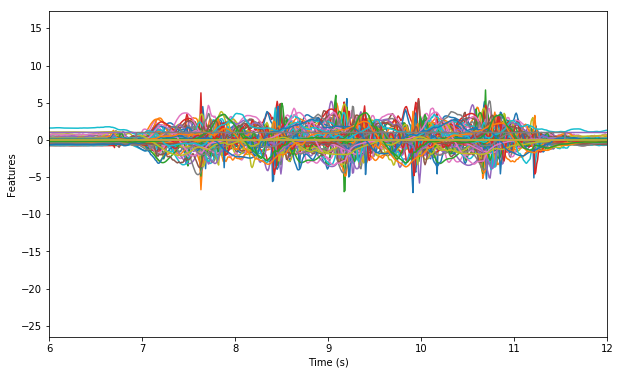

In [4]:
scale_factors = np.std(X, axis=0)
mean_values = np.mean(X, axis=0)
X_prep = (X - mean_values)/scale_factors
#print("After normalizing: ")
#print("Mean is: ", np.mean(X_prep, axis=0))
#print("Stdev. is: ", np.std(X_prep, axis=0))
plt.figure(figsize=(10, 6))
plt.plot(t, X_prep)
plt.plot(t, Y)
plt.xlim([6, 12])
plt.ylabel('Features')
plt.xlabel('Time (s)')
plt.show()

## Trying Logistic Regression

In [5]:
lr_model = Sequential()
lr_model.add(Dense(32, input_dim=nfeat, activation='relu'))
lr_model.add(Dense(3))
lr_model.add(Activation('softmax'))
lr_model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
lr_model.fit(X_prep, Y_prep, epochs=30, batch_size=64)

Epoch 1/30
61207/61207 [==============================] - 1s 16us/step - loss: 0.2316 - acc: 0.9284
Epoch 2/30
61207/61207 [==============================] - 1s 12us/step - loss: 0.1556 - acc: 0.9540
Epoch 3/30
61207/61207 [==============================] - 1s 11us/step - loss: 0.1389 - acc: 0.9582
Epoch 4/30
61207/61207 [==============================] - 1s 11us/step - loss: 0.1285 - acc: 0.9602
Epoch 5/30
61207/61207 [==============================] - 1s 11us/step - loss: 0.1202 - acc: 0.9616
Epoch 6/30
61207/61207 [==============================] - 1s 12us/step - loss: 0.1137 - acc: 0.9637
Epoch 7/30
61207/61207 [==============================] - 1s 11us/step - loss: 0.1087 - acc: 0.9644
Epoch 8/30
61207/61207 [==============================] - 1s 11us/step - loss: 0.1037 - acc: 0.9658
Epoch 9/30
61207/61207 [==============================] - 1s 11us/step - loss: 0.0998 - acc: 0.9665
Epoch 10/30
61207/61207 [==============================] - 1s 11us/step - loss: 0.0964 - acc: 0.9676

### Plot the labels


[[5.7516086e-01 3.7952644e-01 4.5312721e-02]
 [6.5019238e-01 2.9975423e-01 5.0053395e-02]
 [7.5720078e-01 2.0763275e-01 3.5166524e-02]
 ...
 [9.9870384e-01 1.0657321e-03 2.3035283e-04]
 [9.9898809e-01 8.6043897e-04 1.5143407e-04]
 [9.9914277e-01 7.2025420e-04 1.3694666e-04]]


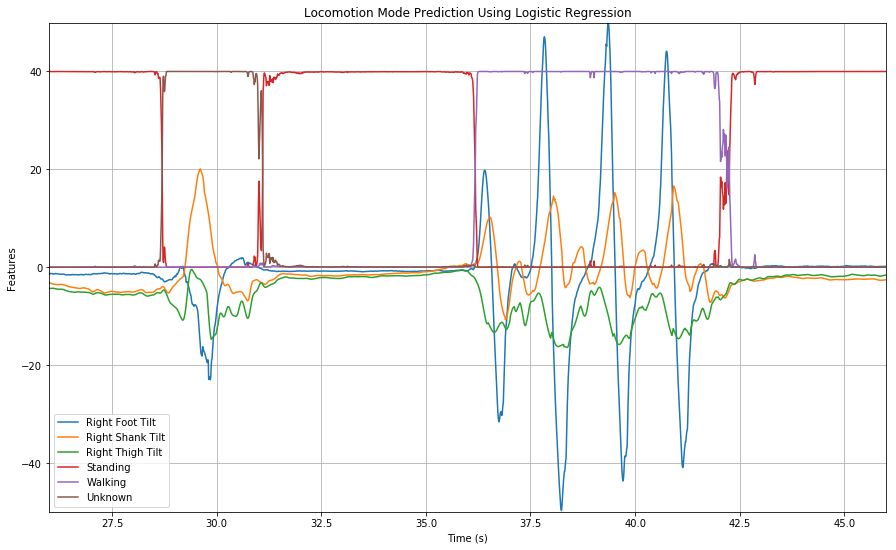

In [6]:
preds = lr_model.predict(X_prep)
print(preds)
plt.figure(figsize=(15, 9))
plt.plot(t, X[:, 56], label='Right Foot Tilt')
plt.plot(t, X[:, 57], label='Right Shank Tilt')
plt.plot(t, X[:, 58], label='Right Thigh Tilt')
plt.plot(t, preds[:, 0]*40, label='Standing')
plt.plot(t, preds[:, 1]*40, label='Walking')
plt.plot(t, preds[:, 2]*40, label='Unknown')
plt.xlim([26, 46])
plt.ylim([-50, 50])
plt.ylabel('Features')
plt.xlabel('Time (s)')
plt.title('Locomotion Mode Prediction Using Logistic Regression')
plt.grid()
plt.legend()
plt.show()

## Using CNNs

### CNN Specific Pre-Processing of the data

In [7]:
# Function to split the data and labels into windows that are causally aligned.
def get_sub_sequences(data_array, y_array, window_size=120, step_size=90, dims=None, seq_out=False, causal=True):
    rows = data_array.shape[0]
    cols = data_array.shape[1]

    if dims == None:
        outdims = [i for i in range(cols)]
    else:
        outdims = dims
        
    sequences = rows//step_size
    out_x = np.zeros((sequences, window_size, len(outdims)))
    if seq_out:
        out_y = np.zeros((sequences, window_size, y_array.shape[1]))
    else:
        out_y = np.zeros((sequences, y_array.shape[1]))
        
    idxs = range(window_size, rows, step_size)    
    
    for i, j in enumerate(idxs):
        out_x[i, :, :] = data_array[j-window_size:j, outdims]
        if seq_out:
            out_y[i, :, :] = y_array[j-window_size:j, :]
        else:
            out_y[i, :] = y_array[j, :]
    
    return out_x, out_y

# Generate dataset of sub-sequences
X_seq, Y_seq = get_sub_sequences(X_prep, Y_prep, window_size=120, step_size=1)
X_seq = np.reshape(X_seq, newshape=(X_seq.shape[0], X_seq.shape[1], X_seq.shape[2], 1))
# Plot some subsequences to make sure that we're doing it right
# plt.figure(figsize=(15, 9))
# for i in range(1, 10, 1):
#     plt.subplot(3, 3, i)
#     plt.plot(X_seq[i*2+590, :, 56:59])
#     plt.title('Subsequence from {}, LM={}'.format(i*2+590, Y_seq[i]))
#     plt.xlabel('Sample')
#     plt.ylabel('Value')
#     plt.grid()

# plt.show()

### Model 1

In [8]:
cnn_model1 = Sequential()
cnn_model1.add(Conv2D(filters=16, kernel_size=9, input_shape=(120, 63, 1), 
                      data_format='channels_last', activation='relu', padding='valid'))
cnn_model1.add(MaxPooling2D(pool_size=(10, 3), padding='valid'))
cnn_model1.add(Flatten())
cnn_model1.add(Dense(3, activation='softmax'))
#cnn_model1.add(Dense(3, activation='softmax'))
cnn_model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model1.summary()
print("X_seq: ", X_seq.shape)
print("Y_seq: ", Y_seq.shape)
cnn_model1.fit(X_seq, Y_seq, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 112, 55, 16)       1312      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 18, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3168)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 9507      
Total params: 10,819
Trainable params: 10,819
Non-trainable params: 0
_________________________________________________________________
X_seq:  (61207, 120, 63, 1)
Y_seq:  (61207, 3)
Epoch 1/1
61207/61207 [==============================] - 328s 5ms/step - loss: 0.1772 - acc: 0.9492


In [1]:

import os

os.getcwd()

'C:\\Users\\Zed_Luz\\OneDrive\\3-MEE\\21-NUS Lab Intern\\Work\\3-IMU-DeepLearning\\ashwin'